In [1]:
# Import all the necessary packages

from os import path
import numpy as np, matplotlib.pyplot as plt
from astropy.io import fits
from photutils.isophote import Ellipse, EllipseGeometry
from photutils.aperture import EllipticalAperture, SkyCircularAperture, CircularAperture, aperture_photometry, ApertureStats
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9 as cosmo
from astropy.wcs import WCS
import astropy.units as u
from astropy import modeling
from astropy.coordinates import SkyCoord
import seaborn as sns
from astropy.stats import sigma_clipped_stats
import pandas as pd

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib

import warnings
warnings.filterwarnings("ignore")

# standard imports for my work
from bpt_utils import *
from read_transients_data import *
from correct_redshift_evolution import *
from generate_bkg_galaxies import *
from helper_functions import *

plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['image.origin'] = 'lower'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk') 
sns.set(font_scale=1.2)
sns.set_palette('colorblind')
sns.set_style('ticks')
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma', 'Verdana', 'Lucida Grande', 'DejaVu Sans']


In [2]:
# specify the FRB name
frb = "mizu"

# read FRBs spectrum data
spectrum_file = "frbs_data/dsa_results/{}/spec_calibrated.csv".format(frb)
dsa_frbs = read_dsa_data()
z = dsa_frbs[dsa_frbs["frb_name"]==frb].reset_index()["redshift"][0]
data = pd.read_csv(spectrum_file)
flux, flux_unc, lam = data["flux"], data["flux_unc"], data["wavelen"]
mask = np.logical_not(np.logical_or(np.isnan(flux), np.isnan(flux_unc)))
mask = np.logical_and(mask, flux_unc>0)
flux, flux_unc = flux[mask], flux_unc[mask]
lam = lam[mask]

# Normalize spectrum to avoid numerical issues
norm = np.median(flux)
flux = flux/norm
flux_unc = flux_unc/norm
rms = np.median(flux_unc)

# Logarithmically rebin the data
flux, loglam, velscale = util.log_rebin(lam, flux)
lam = np.exp(loglam)
lam /= (1+z)
noise = np.abs(flux_unc)


In [3]:
R = 800 # Resolving power of LRIS

# Compute the spectral resolution in wavelength units assuming it is approximately constant
# Spectral resolution FWHM is given by the definition of resolving power, and using as 
# reference the geometric mean of the observed wavelength range.
# Observed wavelength range of LRIS: 0.39–1.1 microns

FWHM_gal = 1e4*np.sqrt(0.39*1.1)/R
print( f"FWHM_gal: {FWHM_gal:.1f} Å")

# Since we have deredshifted the spectra, we need to correct the instrumental dispersion as well
FWHM_gal /= (1 + z)     # Adjust resolution in Angstrom
print(f"de-redshifted FWHM_gal: {FWHM_gal:.1f} Å")

# Compute the instrumental dispersion
c = 299792.458 # speed of light in km/s
sigma_inst = c/(R*np.sqrt(4*np.log(4)))
print( f"sigma_inst: {sigma_inst:.0f} km/s")

velscale = velscale[0]
print(f"Velocity scale per pixel: {velscale:.2f} km/s")

# Set up spectral templates
FWHM_temp = 2.51   # Resolution of E-MILES templates in the fitted range
ppxf_dir = path.dirname(path.realpath(lib.__file__))
pathname = ppxf_dir + '/miles_models/Eun1.30*.fits'

# The templates are normalized to the V-band using norm_range. 
# In this way the weights returned by pPXF represent V-band light fractions of each SSP. 
# I limit the age of the templates to the age of universe at z.
miles = lib.miles(pathname, 
                  velscale, 
                  norm_range=[5070, 5950], 
                  age_range=[0, cosmo.age(z*cu.redshift).value])

# The stellar templates are reshaped below into a 2-dim array with each spectrum as a column, 
# however we save the original array dimensions reg_dim, which are needed to specify the 
# regularization dimensions
reg_dim = miles.templates.shape[1:]
stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

# The emission_lines function defines the most common lines, but additional lines can be 
# included by editing the function in the file ppxf_util.py
lam_range_gal = np.asarray([np.min(lam), np.max(lam)])
gas_templates, gas_names, line_wave = util.emission_lines(miles.ln_lam_temp, 
                                                          lam_range_gal, 
                                                          FWHM_gal, 
                                                          tie_balmer=1)

# Combine the stellar and gaseous templates into a single array
# During the pPXF fit they will be assigned a different kinematic component value
templates = np.column_stack([stars_templates, gas_templates])

# Setup pPXF parameters

# As the spectrum was deredshifted, the starting guess for the velocity becomes close to zero
start = [0, sigma_inst] # (km/s), starting guess for [V, sigma]

# Fit two kinematics components, one for the stars and one for the gas
# Assign component=0 to the stellar templates, component=1 to the gas
n_stars = stars_templates.shape[1]
n_gas = len(gas_names)
component = [0]*n_stars + [1]*n_gas
gas_component = np.array(component) > 0  # gas_component=True for gas templates

# Fit (V, sig) moments=2 for both the stars and the gas
moments = [2, 2]

# Adopt the same starting value for both the stars and the gas components
start = [start, start]

FWHM_gal: 8.2 Å
de-redshifted FWHM_gal: 7.9 Å
sigma_inst: 159 km/s
Velocity scale per pixel: 71.25 km/s
Emission lines included in gas templates:
['Balmer' '[SII]6716' '[SII]6731' 'HeII4687' 'HeI5876' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']


 Best Fit:       Vel     sigma
 comp.  0:       -30       198
 comp.  1:      -130        60
Stars Attenuation A_V: 0.000
  Gas Attenuation A_V: 2.687
chi2/DOF: 2.279e+04; DOF: 2013; degree = 4; mdegree = 8
method = capfit; Jac calls: 8; Func calls: 128; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 10/152
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Balmer      25.95   0.00073    -130    60
Comp:  1             [SII]6716      2.648   0.00082    -130    60
Comp:  1             [SII]6731      2.368   0.00080    -130    60
Comp:  1              HeII4687     0.1497   0.00083    -130    60
Comp:  1               HeI5876     0.5005   0.00091    -130    60
Comp:  1          [OIII]5007_d      2.192    0.0010    -130    60
Comp:  1            [OI]6300_d     0.7426   0.00096    -130    60
Comp:  1        

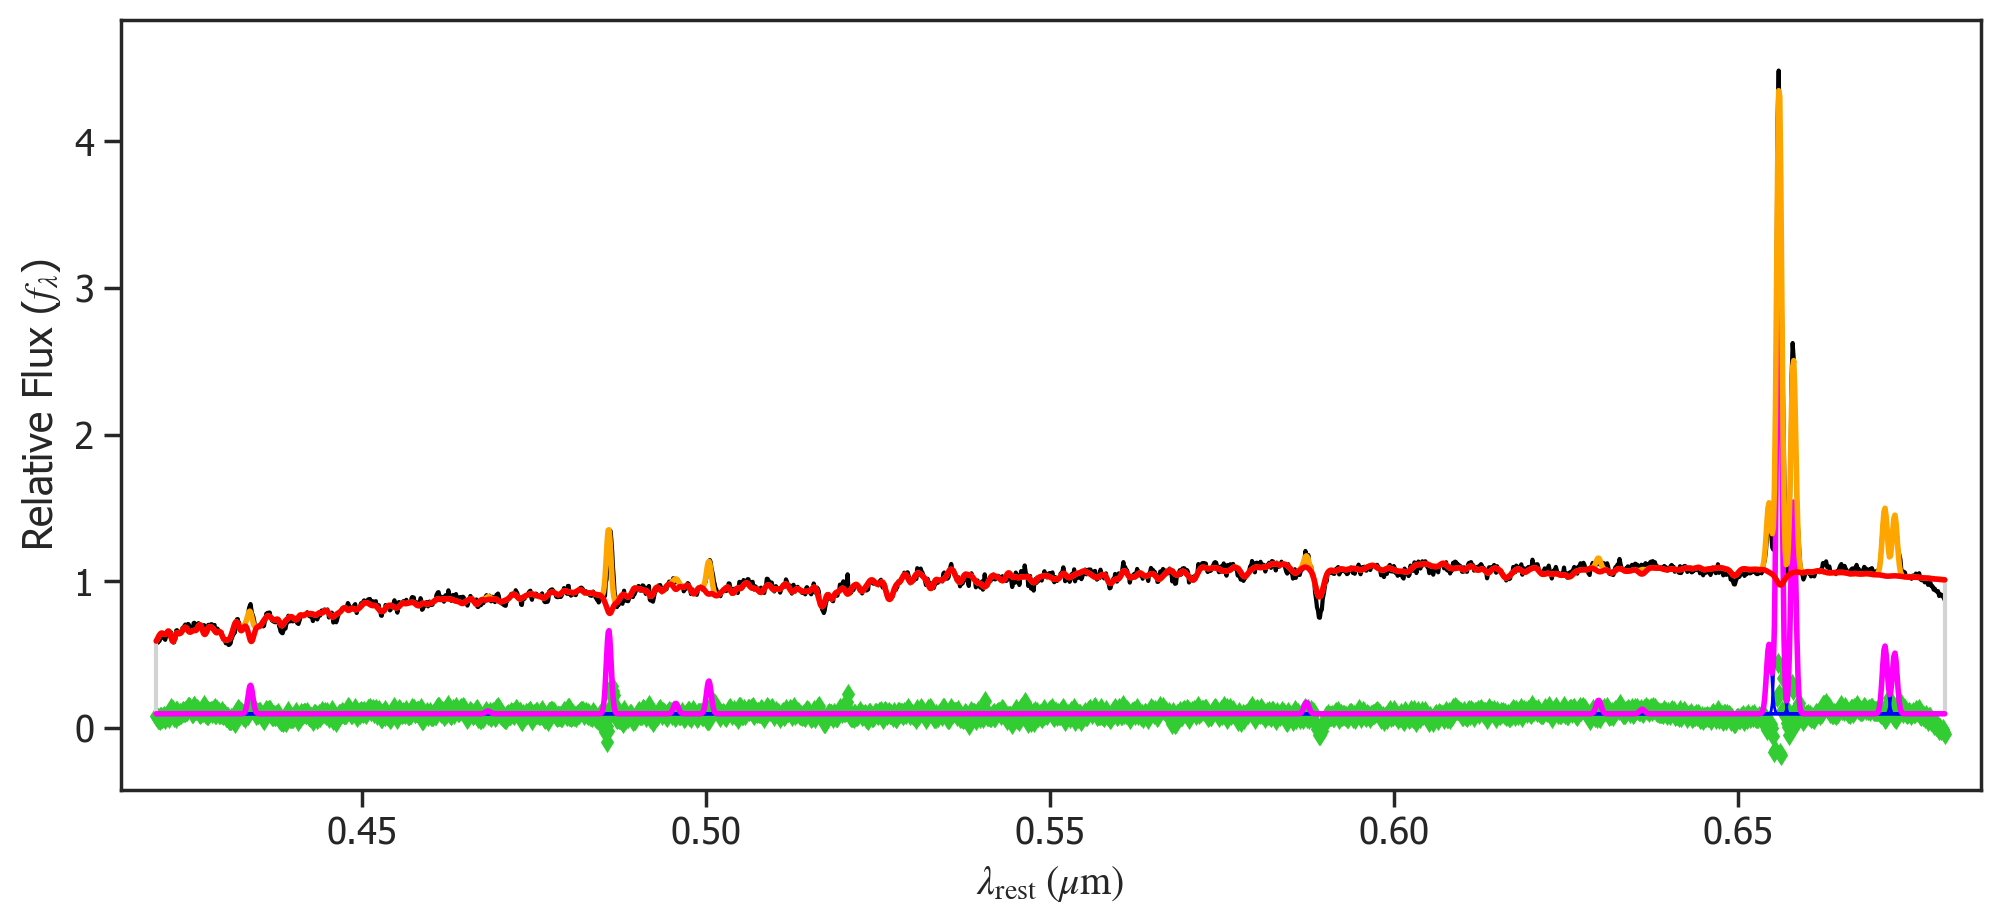

In [4]:
pp = ppxf(templates, np.array(flux), np.array(noise), velscale, start,
          moments=moments, degree=4, mdegree=8, lam=lam, lam_temp=miles.lam_temp, regul=100,
          reg_dim=reg_dim, component=component, gas_component=gas_component, reddening=0, 
          gas_reddening=0, gas_names=gas_names, goodpixels=np.arange(flux.size))
plt.figure(figsize=(12, 5))
pp.plot()

In [5]:
# As the templates have larger instrumental dispersion than the galaxy spectrum, 
# and for this reason it was not possible to match the resolutions of the templates 
# before the fit, I now need to correct the fitted sigma by the quadratic differences 
# in instrumental resolutions.

lam_med = np.median(lam)  # Angstrom
sigma_gal = c*FWHM_gal/lam_med/2.355  # in km/s
sigma_temp = c*FWHM_temp/lam_med/2.355
sigma_obs = pp.sol[0][1]   # sigma is second element of first kinematic component
sigma_diff2 = sigma_gal**2 - sigma_temp**2   # eq. (5) of Cappellari (2017)
sigma = np.sqrt(sigma_obs**2 - sigma_diff2)
print(f"sigma stars corrected: {sigma:.0f} km/s")

# Uncertainties on stellar kinematics. More accurate ones can be obtained with bootstrapping.

errors = pp.error[0]*np.sqrt(pp.chi2) # assume the fit is good
print("Formal errors:")
print("   dV   dsigma")
print("".join("%6.2g" % f for f in errors))

# An improved estimate of the best-fitting redshift is given by the following lines using equation 5 of Cappellari (2022).

errors = pp.error[0]*np.sqrt(pp.chi2) 
vpec = pp.sol[0][0]                         # This is the fitted residual velocity in km/s
znew = (1 + z)*np.exp(vpec/c) - 1           # eq.(5c) Cappellari (2022)
dznew = (1 + z)*errors[0]/c                 # eq.(5d) Cappellari (2022)
print(f"Best-fitting redshift z = {znew:#.6f} +/- {dznew:#.2g}")

sigma stars corrected: 87 km/s
Formal errors:
   dV   dsigma
    11    12
Best-fitting redshift z = 0.036697 +/- 3.7e-05


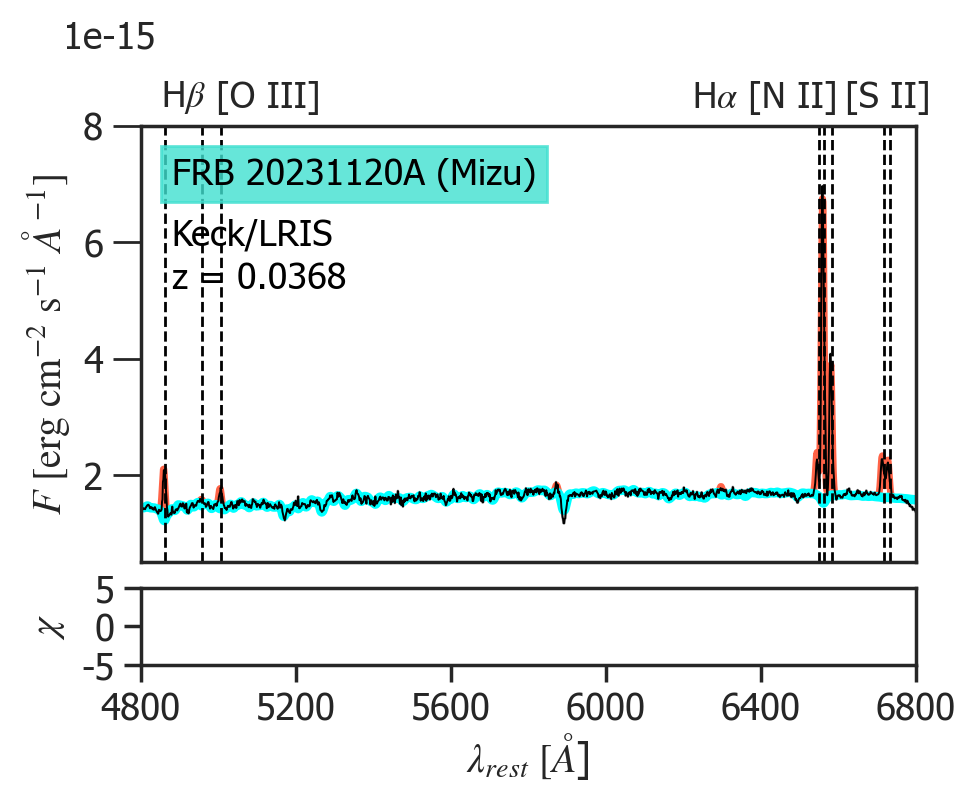

In [6]:
import matplotlib
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(5, 3.5))
grid = plt.GridSpec(11, 16, wspace=1, hspace=1)
ax = plt.subplot(grid[:9, :])
ax1 = plt.subplot(grid[9:, :])

stars_spectrum = (pp.bestfit - pp.gas_bestfit)*norm
gas_spectrum = pp.gas_bestfit*norm
gas_emission = stars_spectrum+gas_spectrum

ax.fill_between(lam, (flux*norm-flux_unc*norm), (flux*norm+flux_unc*norm),
                color="black", alpha=0.2)

ax.plot(lam, gas_emission, 
        color="tomato", linewidth=2.5, linestyle="solid", label="Nebular Emission")

ax.plot(lam, stars_spectrum, 
        color="cyan", linewidth=3.4, linestyle="solid", label="Stellar Continuum")

ax.plot(lam, flux*norm, 
        color="black", linewidth=0.7, linestyle="solid", label="Observed Data")

ax.set_ylabel(r"$F~[\mathrm{erg}~\mathrm{cm}^{-2}~\mathrm{s}^{-1}~\AA^{-1}]$")

ax.tick_params(direction='out', length=6, width=1)
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=4)

label_loc = 8.5e-15

ax.text(4861.35+50, label_loc, r'H$\beta$', ha='center', va='center', fontsize=13)
ax.axvline(4861.35, linestyle="--", color="black", linewidth=1)

ax.axvline(4958.911, linestyle="--", color="black", linewidth=1)
ax.text(4980+150, label_loc, '[O III]', ha='center', va='center', fontsize=13)
ax.axvline(5006.843, linestyle="--", color="black", linewidth=1)

ax.text(6718.29+10, label_loc, '[S II]', fontsize=13, ha='center', va='center')
ax.axvline(6718.29, linestyle="--", color="black", linewidth=1)
ax.axvline(6732.67, linestyle="--", color="black", linewidth=1)

ax.text(6562.8-280, label_loc, r'H$\alpha$', fontsize=13, ha='center', va='center')
ax.axvline(6562.8, linestyle="--", color="black", linewidth=1)

ax.axvline(6549.86, linestyle="--", color="black", linewidth=1)

ax.text(6583-100, label_loc, r'[N II]', fontsize=13, ha='center', va='center')
ax.axvline(6583, linestyle="--", color="black", linewidth=1)

ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax1.plot(lam, (stars_spectrum+gas_emission-(flux*norm))/(flux_unc*norm*100), color="black", lw=0.7)
ax1.set_ylabel(r'$\chi$', labelpad=5)
ax1.set_xlabel(r'$\lambda_{rest}~[\AA$]', labelpad=1)

ax.set_xlim([4800, 6800])
ax1.set_xlim([4800, 6800])
ax1.set_ylim([-5, 5])
ax.set_ylim(0.5e-15, 8e-15)

ax.text(.04, .89, '{} ({}{})'.format(dsa_frbs[dsa_frbs["frb_name"]==frb].reset_index()["FRB_TNS_name"][0],
                                     frb[0].upper(), 
                                     frb[1:]), color="black", ha='left', va='center',
       bbox=dict(facecolor='turquoise', edgecolor='turquoise', alpha=0.8), transform=ax.transAxes, fontsize=13)
ax.text(.04, .75, dsa_frbs[dsa_frbs["frb_name"]==frb].reset_index()["instrument"][0], 
        color="black", ha='left', va='center', transform=ax.transAxes, fontsize=13)
ax.text(.04, .65, 'z = {}'.format(round(float(dsa_frbs[dsa_frbs["frb_name"]==frb].reset_index()["redshift"][0]), 4)), 
        color="black", ha='left', va='center', transform=ax.transAxes, fontsize=13)

import types
pad = 3
def bottom_offset(self, bboxes, bboxes2):
    bottom = self.axes.bbox.ymax
    self.offsetText.set(va="top", ha="left") 
    oy = bottom - pad * self.figure.dpi / 72.0
    self.offsetText.set_position((-0.1, oy+115))

ax.yaxis._update_offset_text_position = types.MethodType(bottom_offset, ax.yaxis)
from matplotlib.ticker import MultipleLocator
ax1.xaxis.set_major_locator(MultipleLocator(400))

